# Попытка построить социальный граф студентов выбранного университета 

## Здесь только создание объекта NetworkX, визуализация же производилась в Gephi

### Импортируем библиотеку api_vk


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import vk_api
import networkx as nx
import pickle

### Авторизация в VK / личный профиль

In [5]:
vk_session = vk_api.VkApi('+79995676080', 'Maxim080')
vk_session.auth()
vk = vk_session.get_api()

### Тело основного запроса

In [6]:
# В переменной table будет храниться результирующая таблица пользователей ВК указавших <университет> как свой вуз

table = pd.DataFrame()
rolling_sum = 0
for i in range(6):    
    
    # Параметры для ограничения возраста от 17 до 22 лет. 
    age = str(i+17)
    
    # Основной запрос для сервера ВК где:
    # код университета = <...>, ограничения в возрасте от 17 до 22, 
    # а запрошенные поля в переменной fields
    
    fields= 'bdate, sex, followers_count, common_count, occupation, nickname, personal, exports, wall_comments, activities, interests, music, movies, tv, books, games, about, quotes, can_post, can_see_audio, can_write_private_message, can_send_friend_request, is_favorite, is_hidden_from_feed, timezone, screen_name, maiden_name, friend_status, career'
    university = '***'
    
    P = vk.users.search(count=1000, university=university, age_from=age, age_to=age, fields=fields)
    
    # В объект DataFrame для удобства
    
    df_temp = pd.DataFrame.from_dict(P['items'], orient='columns')
    df_temp['age'] = (i+17)
    
    # Вывод промежуточных результатов
    print('В возрасте ', str(i+17), 'лет ', df_temp['id'].count(), ' человек указали что <Ваш параметр>')
    
    # Конкатенация таблиц в итоговую
    table = pd.concat([table, df_temp], axis=0, join='outer', ignore_index=True)
    rolling_sum += df_temp['id'].count()
    
print('Всего студентов указало <университет>: ', rolling_sum)    
print('Общая сумма совпадает с количеством строк итоговой таблицы: ', rolling_sum == table['id'].count())

В возрасте  17 лет  61  человек указали что <Ваш параметр>
В возрасте  18 лет  148  человек указали что <Ваш параметр>
В возрасте  19 лет  278  человек указали что <Ваш параметр>
В возрасте  20 лет  392  человек указали что <Ваш параметр>
В возрасте  21 лет  366  человек указали что <Ваш параметр>
В возрасте  22 лет  458  человек указали что <Ваш параметр>
Всего студентов указало <университет>:  1703
Общая сумма совпадает с количеством строк итоговой таблицы:  True


### Сохранение в файл

In [7]:
table.to_excel('table.xlsx', sheet_name='Sheet1')

### Подготовка к извлечению списка друзей

In [8]:
# Формирование списка всех id полученных с сервера ВК
# Если аккаунт закрыт - метод api даст ошибку, так как мы нацелены на ненаправленный граф
# а из найденных мной пользователей лишь 15-17% закрыли аккаунты, потери несущественны

S_id = table[table['is_closed'] == False].reset_index()['id']

### Запрос к серверу вк для извлечения списка друзей каждого id серии S_id. (долгий)

Создан словарь с циклом в теле генератора на длину списка S_id

In [23]:
def list_friends(A):
    DF = {}
    n = 0
    for i in range(len(A)):
        list_friends_temp_in_ugrasu = list(set(A.to_list()) & set(vk.friends.get(count=1000, user_id = A[i])['items']))
        DF.update({A[i]:list_friends_temp_in_ugrasu})
        if len(list_friends_temp_in_ugrasu) == 0:
            n += 1
    print(n)
    return DF


# n добавлен в тело цикла как подсчет количества пользователей, 
# у которых не оказалось друзей среди тех, кого мы собрали в предыдущем шаге

Dict_friends = list_friends(S_id)

739
199
120


### Сохраняем в файл результаты запросов к id

In [24]:
# VK_api достаточно медленный ибо существует ограничение запросов в секунду
# поэтому я сохраняю промежуточный вариант в файлик :)

with open('Dict_friends.pickle', 'wb') as f:
    pickle.dump(Dict_friends, f)
with open('S_id.pickle', 'wb') as f:
    pickle.dump(S_id, f)

In [19]:
# Читаем словарь из файла

with open('Dict_friends.pickle', 'rb') as f:
    Dict_friends_new = pickle.load(f)
    

### Подбор параметров визуализации графа

Создание ненаправленного графа

In [25]:
# NetworkX поддерживает и другие способы создания графа
# как говорится, взял тот, что ближе

def create_graph(DF, ID):
    G = nx.Graph()
    for i in range(len(DF)):
        for j in range(len(DF[ID[i]])):
            G.add_edge(ID[i], DF[ID[i]][j])
    return G

### Создание объекта типа NetworkX

In [29]:
Graph = create_graph(Dict_friends, S_id)

Пытаемся отрисовать граф

<IPython.core.display.Javascript object>


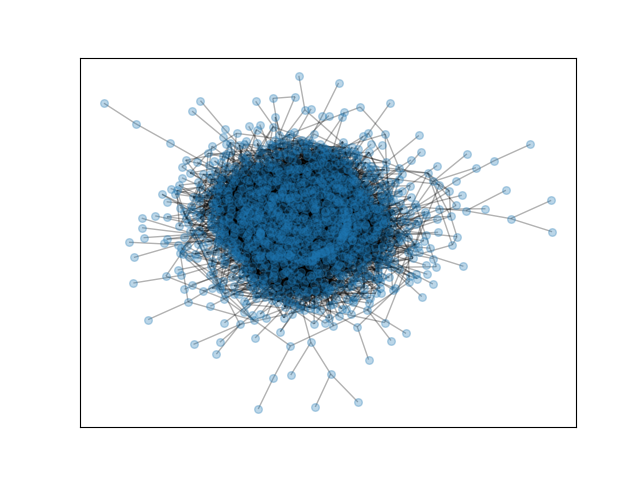

In [57]:
#%matplotlib notebook
#import matplotlib.pyplot as plt

# Укладка - layout - крайне важный процесс, но без интерактивного взаимодействия сущщий ад

# Варинат номер раз:

pos = nx.kamada_kawai_layout(Graph)
nx.draw_networkx(Graph, pos=pos, with_labels = False, alpha=0.3, node_size=30)

<IPython.core.display.Javascript object>


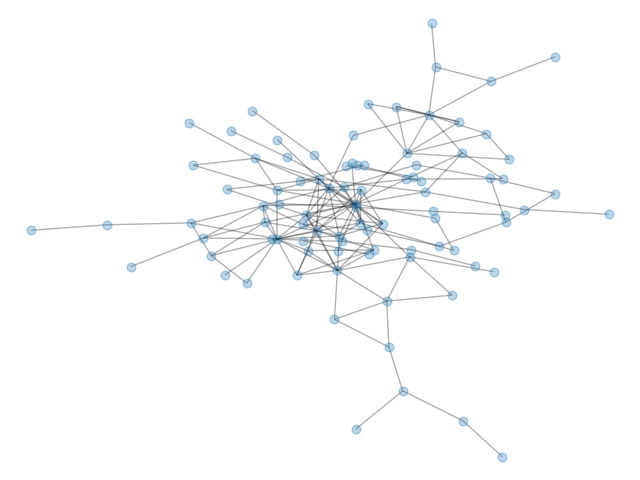

In [60]:
# Номер 2: (усеченная выборка) 

nx.draw_kamada_kawai(Graph, alpha=0.3, node_size=40)

<IPython.core.display.Javascript object>


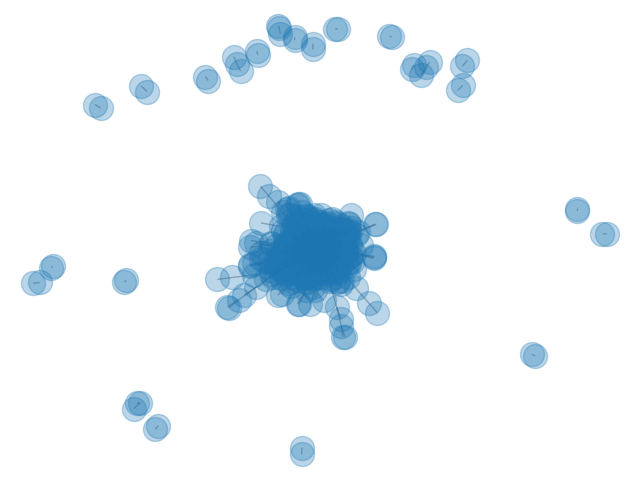

In [21]:
# Вариант 3 - другие параметры визуализации

nx.draw(Graph, alpha=0.3)

## Используем граф для расчета метрик: Кластеризация и центральность. 

In [33]:
# Сворачиваем в функцию для удобства

def data_to_graph(G):
    l_nodes = list(G.nodes)
    l = len(l_nodes)
    
    for i in range(l):
        
        # G - объект DataFrame, для удобства работы с данными
        # собираем таблицу "Нод - характеристика нода"
        
        G.nodes[l_nodes[i]]['cluster'] = nx.clustering(G, nodes=l_nodes[i])
        G.nodes[l_nodes[i]]['closeness'] = nx.closeness_centrality(G, u=l_nodes[i])
        
    print('Количество обработаных нодов: ', l)
    return G

G_all = data_to_graph(Graph)

Количество обработаных нодов:  304
Количество обработаных нодов:  1258


In [43]:
# переводим все в табличку и сохраняем

nx.to_pandas_dataframe(G)
nx.to_pandas_edgelist(G_all).to_excel('edges.xlsx', sheet_name='Sheet1')

In [46]:
pd.DataFrame(list(G_all.nodes)).to_excel('nodes.xlsx', sheet_name= 'Sheet1')

## Получаем таблицу с данными для каждого пользователя, на основе которых можно строить дальнейшую аналитику и разные предиктивные модельки) 

Я кстати перегрузил все в Gephi и построил прикольные картинки есть в репо. 